In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const


In [2]:
## Two-body dynamics: setting up Leapfrog method

In [3]:
def f(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
    # position of mass1, mass2    
    x1, y1 = rs[0], rs[1]  
    x2, y2 = rs[2], rs[3] 
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # x, y components of Acceleration 'a'
    ax1 = G*m2*(x2 - x1)/r**3    
    ay1 = G*m2*(y2 - y1)/r**3    
    ax2 = G*m1*(x1 - x2)/r**3    
    ay2 = G*m1*(y1 - y2)/r**3    
    
    return np.array([ax1, ay1, ax2, ay2], float)
    

Reference: [A Simple Leapfrog Integration Scheme to Find Optimal Interplanetary Trajectories by Scott M. Kelley](https://ir.library.oregonstate.edu/downloads/cc08hm643)https://ir.library.oregonstate.edu/downloads/cc08hm643)

The basic equations of motion of the leapfrog integration scheme are

$$r_{i+1} = r_i + v_{i+\frac{1}{2}} \Delta t \\
v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_i \Delta t. $$

This system of equations can be rewritten without the explicit use of half-steps by first
expressing the velocity term for a full step in two distinct half-steps

$$v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_i \Delta t \\
v_{i+1} = v_{i+\frac{1}{2}} + \frac{a_{i+1}}{2} \Delta t. $$

Combining above equations allows the equations of motion to be written strictly in terms of integer timesteps:

$$r_{i+1} = r_i + v_i \Delta t + \frac{a_i}{2}\Delta t^2 \\
v_{i+1} = v_i + \frac{(a_i + a_{i+1})}{2} \Delta t $$

In [4]:
def leapfrog(t0, tmax, r0, v0, h, f, ref_val, err_tol,  **kwargs):
    """                                                                                                                      
    Calculate a soln r(t) to a 1st-order ODE of the form r'(t)=f(r,t).                                                 
                                                                                                                             
    Uses the leapfrog method.    
    
    Inputs: 
    t0 & tmax (Init & final time) 
    r0 (Init pos of m1)
    v0 (Init velocity of m1)
    h (step size)
    f (function to obtain accelaration)
    ref_val: expected value for reference (r or total Energy)
    err_tol: amount of allowed deviation from ref_val
    
    Returns: 
    t (array for time steps)
    X & Y (arrays for position coordinates of both objects)
    v_ (array of velocities of both objects)
    err (array for relative err in position)
    
    """
    
    debug = False
    q = m1/m2
    x1, y1 = r0, 0
    x2, y2 = -q*r0,0
    vx1, vy1 = 0, v0
    vx2, vy2 = 0,-q*v0
    
    
    # Initialize array for time at each step
    ti = t0
    t = np.array(ti)
    
    # initialize arrays of positions at each step
    r = np.array([x1, y1, x2, y2], float)
    R = np.array([r])
    
    # initialize arrays of velocities at each step
    vinit = np.array([vx1, vy1, vx2, vy2], float)
    v_ = np.array([vinit]) 
    vi = vinit
    
    # Initialize steps for error check for circular orbit
    if ecc == 0: #circular orbit
        r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
        rel_err = (ref_val - r_check)/ref_val
    
    elif ecc > 0 and ecc < 1: #elliptical orbit
        v1_sq = vi[0]**2 + vi[1]**2
        v2_sq = vi[2]**2 + vi[3]**2
        r12 = np.sqrt((r[2]-r[0])**2 + (r[3]-r[1])**2)
        E_check = 0.5*(m1*v1_sq + m2*v2_sq) - (G*m1*m2)/r12 #KE_1 + KE_2 + PE
        rel_err = (ref_val - E_check)/ref_val
    
    else: # parabolic orbit
        v1_sq = vi[0]**2 + vi[1]**2
        v2_sq = vi[2]**2 + vi[3]**2
        r12 = np.sqrt((r[2]-r[0])**2 + (r[3]-r[1])**2)
        E_check =  v2_sq*0.5 - (G*M)/r12
        rel_err = (ref_val - E_check)/ref_val
    
    err = np.array([rel_err])
    
    # solve eqns of motion using leapfrog method
    while np.abs(rel_err) < err_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            if debug: print(ti, r, np.abs(r_check - ref_val))
            # update t, r, v_mid
            ti += h
            ri = r +  h*vi + 0.5*f(r)*h**2
            vi = vi + 0.5*h*(f(r) + f(ri))
            r = ri
            #print(f(r))

            # calculate new rel error
            if ecc == 0: #circular orbit
                r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
                rel_err = (ref_val - r_check)/ref_val
                #print(f"init err: {rel_err}")
            elif ecc >0 and ecc < 1:
                v1_sq = vi[0]**2 + vi[1]**2
                v2_sq = vi[2]**2 + vi[3]**2
                r12 = np.sqrt((r[2]-r[0])**2 + (r[3]-r[1])**2)
                E_check = 0.5*(m1*v1_sq + m2*v2_sq) - (G*m1*m2)/r12
                rel_err = (ref_val - E_check)/ref_val
            else:
                v1_sq = vi[0]**2 + vi[1]**2
                v2_sq = vi[2]**2 + vi[3]**2
                r12 = np.sqrt((r[2]-r[0])**2 + (r[3]-r[1])**2)
                E_check =  v2_sq*0.5 - (G*M)/r12
                rel_err = (ref_val - E_check)/ref_val
            

            # save t, r, phi_mid
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            v_ = np.append(v_, np.array([vi]), axis=0)
            err = np.append(err, rel_err) # relative error
    
    # components of cartesian coords
    # R: [x1, x2, y1, y2]
    X = R[:,[0,2]]  # x1, x2
    Y = R[:,[1,3]]  # y1, y2
    return t, X, Y, v_ , err


In [32]:
# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# orbit parameters
m1 = 1e12 # Msun
m2 = 1e12 # Msun
M = m1 + m2
rmin = 25 #kpc #for parabolic encounter

# runtime initial conditions
t0, tmax = 0, 5000
h = 1 #1e-3

a = 100 # (G*M*T**2/(4*np.pi**2))**(1/3)   # semi-major axis (kpc, Kepler's Law)
ecc = 1 #0.08 #1e-12 
 
# starting position of first galaxy from COM
r0 = m2*a/M
# starting velocity of the second galaxy
v0 = np.sqrt(G*m2/a)*np.sqrt((m2*(1-ecc**2))/M)


if ecc == 0: #circular orbit
    p = a
    ref_val = r0
    err_tol = 1e-5
elif ecc > 0 and ecc <1: #elliptical orbit
    p = a*(1 - ecc**2)   # semi-latus rectum (kpc)
    E_ref = -G*m1*m2/(2*a)
    ref_val = E_ref
    err_tol = 1
elif ecc == 1: # parabolic orbit
    p = 2*rmin
    ref_val = -0.55
    err_tol = 1
else:
    print("Unacceptable eccentricity value!")


In [27]:
# leapfrog(t0, tmax, r0, v0, h, f, r_ref, err_tol, **kwargs)
t, X, Y, v_, err =  leapfrog(t0, tmax, r0, v0, h, f, ref_val, err_tol)


cumulative error over 368 Myr: 276.148.


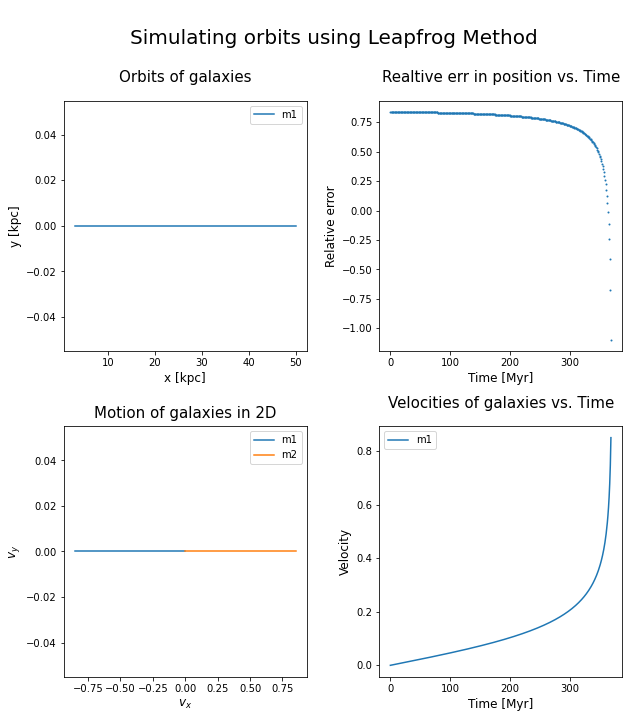

In [36]:
fig = plt.figure(figsize=(10,10))

plt.subplot(221)#, aspect='equal')
plt.plot(X[:,0], Y[:,0], label="m1")
#plt.plot(X[:,1], Y[:,1], label="m2")
plt.xlabel("x [kpc]", fontsize=12), plt.ylabel("y [kpc]", fontsize=12)
plt.legend()
plt.title("Orbits of galaxies", fontsize='15', y=1.05)

plt.subplot(222,aspect='auto')
plt.scatter(t, err, s=1)
#plt.ylim(err_tol*np.array([-1,1]))
#plt.ylim([-0.025,0.025])
plt.xlabel("Time [Myr]", fontsize=12), plt.ylabel("Relative error", fontsize=12)
plt.title("Realtive err in position vs. Time" , fontsize='15', y=1.05)
print(f"cumulative error over {t[-1]} Myr: {sum(err):.6}.")

plt.subplot(223,aspect='auto')
plt.plot(v_[:,0], v_[:,1], label="m1")
plt.plot(v_[:,2], v_[:,3], label="m2")
plt.title("Motion of galaxies in 2D", fontsize='15', y=1.01)
plt.legend()
plt.xlabel("$v_{x}$", fontsize=12), plt.ylabel("$v_y$", fontsize=12)

plt.subplot(224,aspect='auto')
plt.plot(t, np.sqrt(v_[:,0]**2 + v_[:,1]**2), label="m1" )
#plt.plot(t, np.sqrt(v_[:,2]**2 + v_[:,3]**2), label="m2" )
plt.title("Velocities of galaxies vs. Time", fontsize='15', y=1.05)
plt.legend()
plt.xlabel("Time [Myr]", fontsize=12), plt.ylabel("Velocity", fontsize=12)


fig.suptitle("\nSimulating orbits using Leapfrog Method\n", fontsize = '20')
fig.subplots_adjust(hspace=0.3,wspace=0.3,top=0.85,bottom=0.05)
plt.show()


Text(0.5, 1.05, 'Orbits of galaxies')

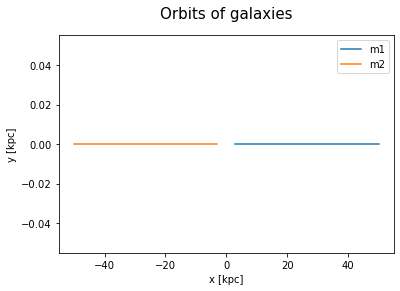

In [31]:
plt.plot(X[:,0], Y[:,0], label="m1")
plt.plot(X[:,1], Y[:,1], label="m2")
plt.xlabel("x [kpc]"), plt.ylabel("y [kpc]")
plt.legend()
plt.title("Orbits of galaxies", fontsize='15', y=1.05)
